In [2]:
import os
import math
from tqdm import tqdm
import itertools

import numpy as np
import raster_geometry as rg

In [5]:
def turn_to_voxel(file, GRID, AUGMENTATION, file_for_scale=None):
    
    def transformation(point, min, max, GRID):
        """
        Compute coordinates in voxelled volume from mesh coordinates
        """
        coord = []
        for point, min, max in zip(point, min, max):
            coord.append(int((point-min)/(max-min)*(GRID-1)))
        return tuple(coord)
    
    
    def augmentation(volume, value, coord, lat=None):
        """
        Add current voxels to the volume as square with the size of 2*ADDITIONAL(lat)+1 side and coodr as center
        """
        # if no augmentation only add dot into volume
        if lat is None:
            volume[coord] = value
            return volume
        coord_min, coord_max = [0]*3, [0]*3
        # compute the coords of current voxel
        for dim in range(3):
            coord_min[dim] = int(np.max((0,coord[dim]-lat)))
            coord_max[dim] = int(np.min((coord[dim]+lat+1, GRID)))

        # if there are neighbouring current dots it is importsnt to adjust additional voxels. For now if values of augmented voxels conpemplate the value = mean(value1, value2)
        old_values = volume[coord_min[0]:coord_max[0],
                            coord_min[1]:coord_max[1],
                            coord_min[2]:coord_max[2],]
        volume[coord_min[0]:coord_max[0],
            coord_min[1]:coord_max[1],
            coord_min[2]:coord_max[2],] = value
        if (old_values != 0).any():
            old_values[tuple(np.nonzero(old_values))] = (old_values[tuple(np.nonzero(old_values))]+value)/2.
            volume[coord_min[0]:coord_max[0],
                   coord_min[1]:coord_max[1],
                   coord_min[2]:coord_max[2],] = old_values
        return volume
    

    volume = np.zeros((GRID, GRID, GRID)) 
    min, max = [0]*3, [0]*3
    if file_for_scale is None: file_for_scale = file
    # compute the values ranges for scaling
    for dim in range(3):
        min[dim] = np.min(file_for_scale[:,dim])
        max[dim] = np.max(file_for_scale[:,dim])

    for point in file:
        coord = transformation(point[:3], min, max, GRID)
        volume = augmentation(volume, point[3], coord, AUGMENTATION)

    return volume

In [6]:
def add_negative_sphere(coords, GRID, SPHERE_VALUE, *additional_volumes):
    """
    Replacing the zeros in the centre of the volume with the negative values might help our model to train.
    """
    

    holed_volumes = []
    eucl_dists = []

    # coordinate of the center in all 3 dimentions
    grid_center = math.ceil(GRID/2)

    # compute the distance to all non-zero voxels from center of volume
    for point in coords:
        eucl_dists.append(np.linalg.norm(tuple(dimention - grid_center for dimention in point)))

    # get te closest current point
    radius = np.sort(eucl_dists)[0]
    print('Sphere radius: ' + str(radius))

    # draw the sphere mask
    sphere = rg.sphere(shape=(GRID, GRID, GRID), radius=math.floor(radius), position=(grid_center,grid_center,grid_center)).astype(np.int_)
    
    # draw sphere into the volumes
    for volume in additional_volumes:
        volume[sphere == 1] = SPHERE_VALUE
        holed_volumes.append(volume)
    
    return holed_volumes

In [7]:
def preprocess_meshes(electrodes_dir, labels_dir, file_path, GRID=65, paired_scale=False,
                      AUGMENTATION=None, add_hole=None, SPHERE_VALUE=-20):
    """

    Saves processed dipole currents and electrodes values as np.array in 3D shape of GRID.

    Parameters
    ----------

    electrodes_dir, labels_dir, file_path: str
        Directory of electrode files, brain currents files, and saving dir
    GRID: int
        The size of zquared voxel model, better to make it odd as center is needed for sphere
    paired_scale: True, False
        Whether the same scale used for input and output is used
        (input for both as electrode always surround brain surface with current values)
    AUGMENTATION: int
        How many additional pixels arround current dot get non-zero value
        (for now the same as the main voxel, later may be beter to include prob function)
    add_hole: True, False, None
        Add fulled shere with negative values inside brain surphase. True - the shpere
        is added to both files (the sphere radius is the same). not None - the sphere
        is added only to output file with brain currents
    SPHERE_VALUE: int
        The value to fill the sphere
    """

    
    # create new directories for voxeled models, created with given parameters
    
    
    if not os.path.isdir(os.path.join(file_path, f'GRID-{GRID}')):
        os.mkdir(os.path.join(file_path, f'GRID-{GRID}'))
    
    if not os.path.isdir(os.path.join(file_path, f'GRID-{GRID}', f'paired_scale-{paired_scale}')):
        os.mkdir(os.path.join(file_path, f'GRID-{GRID}', f'paired_scale-{paired_scale}'))   

    if not os.path.isdir(os.path.join(file_path, f'GRID-{GRID}', f'paired_scale-{paired_scale}', f'AUGMENTATION-{AUGMENTATION}')):
        os.mkdir(os.path.join(file_path, f'GRID-{GRID}', f'paired_scale-{paired_scale}', f'AUGMENTATION-{AUGMENTATION}'))

    to_save_dir = os.path.join(file_path, f'GRID-{GRID}', f'paired_scale-{paired_scale}', f'AUGMENTATION-{AUGMENTATION}')

    os.mkdir(os.path.join(to_save_dir, 'electrodes'))
    os.mkdir(os.path.join(to_save_dir, 'dipoles'))

    for electrode_filename, labels_filename in tqdm(zip(os.listdir(electrodes_dir), os.listdir(labels_dir))):
        # load pair of input/output
        electrodes_file = np.load(os.path.join(electrodes_dir, electrode_filename))
        labels_file = np.load(os.path.join(labels_dir, labels_filename))

        # rescale both files into volumes
        if paired_scale is True:
            electrodes_volume = turn_to_voxel(electrodes_file, GRID, AUGMENTATION)
            labels_volume = turn_to_voxel(labels_file, GRID, AUGMENTATION, electrodes_file)
        else: # each file is scaled separately - image inscribed into square
            electrodes_volume = turn_to_voxel(electrodes_file, GRID, AUGMENTATION)
            labels_volume = turn_to_voxel(labels_file, GRID, AUGMENTATION)
        if add_hole is True: # the shpere is added to both files (the sphere radius is the same)
            labels_volume, electrodes_volume = add_negative_sphere(labels_file[:,:3], SPHERE_VALUE, labels_volume, electrodes_volume)
        elif add_hole is not None: # the sphere is added only to output file with brain currents
            labels_volume, _ = add_negative_sphere(labels_file[:,:3], GRID, SPHERE_VALUE, labels_volume)
        
        np.savez_compressed(os.path.join(to_save_dir, f'electrodes/{electrode_filename}'), electrodes_volume, allow_pickle=True)
        np.savez_compressed(os.path.join(to_save_dir, f'dipoles/{labels_filename}'), labels_volume, allow_pickle=True)

In [8]:
file_path = 'C:/Users/spaik/Documents/lab/ML_project/data/1.3.23_dense_dip/162-dip__ico2/Parcellation_64-lbl/train'
electrodes_dir = 'C:/Users/spaik/Documents/lab/ML_project/data/1.3.23_dense_dip/162-dip__ico2/Parcellation_64-lbl/input'
labels_dir = 'C:/Users/spaik/Documents/lab/ML_project/data/1.3.23_dense_dip/162-dip__ico2/Parcellation_64-lbl/output'

parameters = {'AUGMENTATION': [None, 2], 'GRID': [65, 129], 'paired_scale': [False, True]}
combinations = itertools.product(*(parameters[name] for name in parameters))
# print(list(combinations))

for (AUGMENTATION, GRID, paired_scale) in list(combinations):
    preprocess_meshes(electrodes_dir, labels_dir, file_path, AUGMENTATION=AUGMENTATION, GRID=GRID, paired_scale=paired_scale)

4000it [02:06, 31.59it/s]
4000it [01:23, 48.13it/s]
4000it [08:59,  7.42it/s]
4000it [09:00,  7.41it/s]
4000it [02:29, 26.79it/s]
4000it [02:37, 25.34it/s]
4000it [10:54,  6.11it/s]
4000it [10:50,  6.15it/s]


In [1]:
## Renaming files

# path = 'C:/Users/spaik/Documents/lab/ML_project/data/1.3.23_dense_dip/162-dip__ico2/AB__1005eeg-128__ico2-dip__ico4-bem__fwd/Parcellation_64-lbl/AB__1005eeg-128__ico2-dip__ico4-bem__fwd'
# for filename in os.listdir(path):
#     os.rename(filename, ('AB_' + filename))

In [194]:
# import pyvista as pv
# electrodes = 'C:/Users/andru/Downloads/Telegram Desktop/Razorenova_128-eeg1005_ico4-dip_ico4-bem/Parcellation_2-lbl/2-lbl_dip-0.npy'

# eeg_data = eeg[:,-1]
# eeg_data = eeg_data[:, np.newaxis]
# z = np.zeros(eeg_data.shape)
# eeg_data = 255*np.concatenate((eeg_data, z, z), axis=1)

# eeg_mesh = pv.PolyData(eeg[:,:-1])
# eeg_mesh["colors"] = eeg_data.astype(np.uint8)

# pl = pv.Plotter()
# pl.add_mesh(eeg_mesh, scalars="colors", rgb=True)
# pl.show()

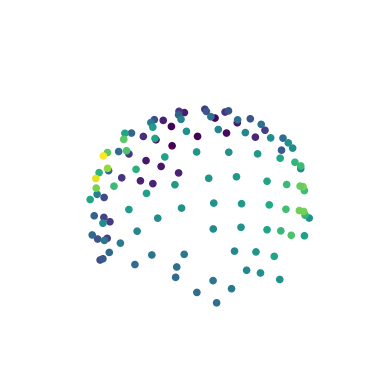

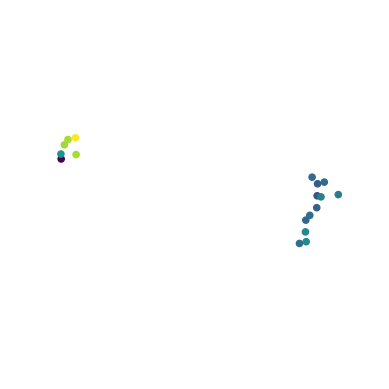

In [188]:
# to check the output

# import matplotlib.pyplot as plt
# electrodes = 'C:/Users/andru/Downloads/Telegram Desktop/Razorenova_128-eeg1005_ico4-dip_ico4-bem/train/65_False_None_None_-20/input/2-lbl_dip-0.npy'
# curr = 'C:/Users/andru/Downloads/Telegram Desktop/Razorenova_128-eeg1005_ico4-dip_ico4-bem/train/65_False_None_None_-20/output/2-lbl_eeg-0.npy'
# eeg = np.load(electrodes)
# dic = np.load(curr)
# sprase = np.array(np.nonzero(eeg))
# values = eeg[np.nonzero(eeg)]

# x,y,z = np.nonzero(dic)
# values_d = dic[np.nonzero(dic)]
# # print(eeg)
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# ax.scatter(sprase[0], sprase[1], sprase[2], c=values, alpha=1)
# ax.axis('off')
# plt.show()

# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# ax.scatter(x,y,z, c=values_d, alpha=1)
# ax.axis('off')
# plt.show()